# Camera Calibration
## Computer Vision and Image Processing - Lab Session 3 Excerices Solutions
### Prof: Luigi Di Stefano, luigi.distefano@unibo.it
### Tutor: Pierluigi Zama Ramirez, pierluigi.zama@unibo.it - Riccardo Spezialetti, riccardo.spezialetti@unibo.it

## Exercise 0: Calibrate your own camera (or Sample Camera)

Try to reimplement the code explained in the theory. Acquire a set of images with a camera (e.g. your mobile phone camera) and calibrate it. For the calibration target print the chessboard.pdf in a A4 paper.
If you are not able to use a camera use the sample images contained in "calibration_images/*.jpg"

In [18]:
# Write here your solution
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

dirname = "new_chessboards/"
img_names = os.listdir(dirname)
img_names = [dirname+name for name in img_names]

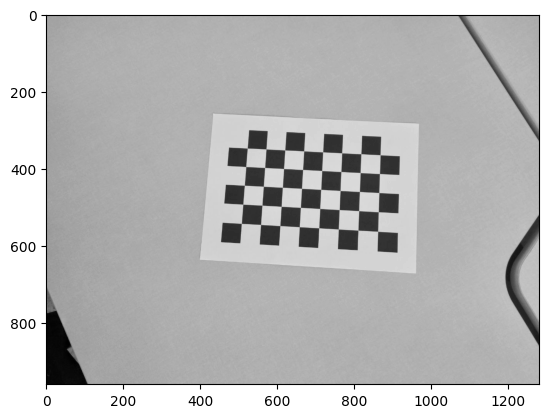

In [19]:
img_index = 0
img = cv2.imread(img_names[img_index], cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.show()

In [20]:
H, W = img.shape[:2]
PATTERN_SIZE = (8,5)
found, corners = cv2.findChessboardCorners(img, PATTERN_SIZE)
print(found)

True


In [21]:
if found:
    term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
    cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)

In [22]:
SQUARE_SIZE = 26.5
coords_3D = np.indices(PATTERN_SIZE, dtype=np.float32) * SQUARE_SIZE
coords_3D = np.transpose(coords_3D, [2, 1, 0])
coords_3D = coords_3D.reshape(-1, 2)
COORDS_3D = np.concatenate([coords_3D, np.zeros([coords_3D.shape[0], 1], dtype=np.float32)], axis=-1)


In [43]:
def processImage(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img.shape[0] != H:
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    if img is None:
        print("Failed to load", img_path)
        return None
    
    found, corners = cv2.findChessboardCorners(img, PATTERN_SIZE)
    if found:
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
        cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)
        # vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        # cv2.drawChessboardCorners(vis, PATTERN_SIZE, corners, found)
        # plt.figure(figsize=(20,10))
        # plt.imshow(vis)
        # plt.show()
    else:
        print('Chessboard not found')
        return None
    
    return (corners.reshape(-1, 2), COORDS_3D)
    

In [44]:
chessboards = [processImage(img_path) for img_path in img_names]
chessboards = [x for x in chessboards if x is not None]

In [45]:
obj_points = [] #3D points
img_points = [] #2D points

for (points_2D, points_3D) in chessboards:
        img_points.append(points_2D)
        obj_points.append(points_3D)

In [46]:
rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, (W, H), None, None)
print("\nRMS:", rms)
print("camera matrix:\n", camera_matrix)
print("distortion coefficients: ", dist_coefs.ravel())
print("Rotation vectors:", rvecs)
print("translation vectors", tvecs)


RMS: 0.22719785728158676
camera matrix:
 [[969.74054652   0.         633.0172921 ]
 [  0.         968.49329136 478.9873912 ]
 [  0.           0.           1.        ]]
distortion coefficients:  [-2.45396582e-02  3.20688149e-01 -2.57117996e-04 -1.30924555e-03
 -2.04066659e-01]
Rotation vectors: [array([[-0.06069156],
       [-0.19374363],
       [-3.0765037 ]]), array([[-0.00805725],
       [-0.06689097],
       [ 1.03073691]]), array([[0.06373818],
       [0.3102026 ],
       [0.04755383]]), array([[-0.92801707],
       [ 0.37568921],
       [ 0.78753497]]), array([[ 0.1286775 ],
       [-0.90574947],
       [ 1.54623858]]), array([[-0.90090024],
       [-0.63930633],
       [-1.24570687]]), array([[-0.31355096],
       [-0.52564274],
       [ 2.4066001 ]]), array([[ 0.59831861],
       [-0.5172549 ],
       [-1.71675154]]), array([[-1.35211188],
       [ 0.42887608],
       [ 2.37456005]]), array([[-0.86010221],
       [ 0.51865341],
       [ 0.94155624]]), array([[-0.76408233],
    

In [47]:
# FOR EACH PICTURE you find an extrinsic matrix
img_index = 0 
rotation_matrix = cv2.Rodrigues(rvecs[img_index])[0]
translation_matrix = tvecs[img_index]
extrinsics_matrix = np.concatenate([rotation_matrix,translation_matrix], axis=1)

In [51]:
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (W, H), 1, (W, H))
print(roi)

(17, 22, 1246, 916)


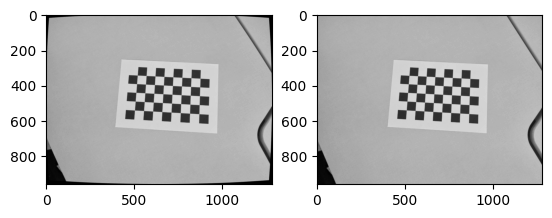

In [54]:
img_undistorted = cv2.undistort(img, camera_matrix, dist_coefs, None, newcameramtx)
plt.subplot(1, 2, 1)
plt.imshow(img_undistorted, cmap="gray", vmin=0, vmax=255)
plt.subplot(1, 2, 2)
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.show()

## Exercise 1A: 3D-2D correspondence

Using image "chessboards/0.jpg" and the calibration results, find the 2D point correspondent to the 3D point (53, 53, 0) and draw a red circle around it.
Solve the exercise in two different ways:

* Use the OpenCV function cv2.projectPoints(objectPoints, rvec, tvec, cameraMatrix, distCoeffs).
* Do it "manually" using the PPM matrix derived from the calibration parameters obtained in the previous exercise.

[764.257  458.4837]


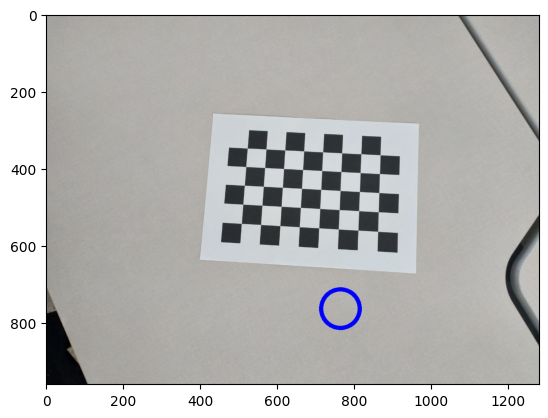

In [96]:
# Write here your solution
img = cv2.imread(img_names[img_index])
circle_center_3d = np.float32([[53, 53, 0]])
circle_center_2d, _ = cv2.projectPoints(circle_center_3d, rvecs[img_index], tvecs[img_index], camera_matrix, dist_coefs)

circle_center_2d = circle_center_2d[0][0]
print(circle_center_2d)

cv2.circle(img, (circle_center_2d[0], circle_center_2d[0]), 50, (255, 0, 0), 10)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [102]:
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (W, H), 1, (W, H))
x, y, w_2, h_2 = roi
img_undistorted = cv2.undistort(img, camera_matrix, dist_coefs, None, newcameramtx)

In [103]:
hom_coord_circle_center_3d = np.concatenate((circle_center_3d, [[1]]), axis=-1)

In [104]:
manual_circle_center_2d = newcameramtx @ extrinsics_matrix @ hom_coord_circle_center_3d.T
manual_circle_center_2d /= manual_circle_center_2d[-1]
manual_circle_center_2d
# draw circle
# crop away black pixels from distortion with
img_undistorted = img_undistorted[y:y+h_2, x:x+w_2]


array([[767.56207735],
       [458.14400292],
       [  1.        ]])

## Exercise 1 B:
Find the 3D point correspondent to the 2D point of the (2,2) corner. Do it first using the PPM derived from the calibration parameters and then using a new homography (calculated with cv2.findHomography).

The expected result is approximately (53,53,0).

In [110]:
# Write here your solution
# PPM
chessboard = processImage(img_names[img_index])
_2d_point = chessboard[0][PATTERN_SIZE[0]*2 + 2]
hom_2d_point = np.concatenate([_2d_point, [1]])

PPM = newcameramtx @ extrinsics_matrix
homography = np.concatenate([PPM[:, :2], PPM[:,3:]], axis=1)
hom_3d_point = np.linalg.inv(homography) @ hom_2d_point
hom_3d_point /= hom_3d_point[-1]

_3d_point = hom_3d_point
_3d_point[-1] = 0
print(_3d_point)

# cv2
homography = cv2.findHomography(chessboard[1], chessboard[0], 0)[0]
hom_3d_point = np.linalg.inv(homography) @ hom_2d_point
hom_3d_point /= hom_3d_point[-1]

_3d_point = hom_3d_point
_3d_point[-1] = 0
print(_3d_point)


[54.59830343 52.6322451   0.        ]
[52.92038233 52.88868665  0.        ]


## Exercise 2: 3D Measureaments in mm

Take an image with an object belonging to same plane of the chessboard (the chessboard has to be in the image). If you cannot use your camera try on "es2/pen.jpg".

Measure the lenght of that object in mm. 

Get the 2D image coordinates using the Image Visualization Tool in LabSession3Exercise3VisualizationTool.ipynb

Expected_results: 145.56mm

<img src="LabSession3Images/pen_lenght.png" width=256>

**Tips (Only if needed)**
* Find the homography given 2D-3D correspondences
* Get the coordinate of two pixels of the object
* Apply the same transformation as in Exercise 1b to get the 3D coordinate of those pixels
* Find the euclidean distance between two 3D points to get your mesuraments

In [114]:
# Write here your solution
_2d_coords, _3d_coords = processImage(img_names[img_index]) 
point_1 = [2701,1156]
point_2 = [2675,2651]

homography = cv2.findHomography(_2d_coords, _3d_coords, 0)[0]

def get_3d_from_2d_homography(_2d_point, homography):
    hom_2d_point = np.concatenate([_2d_point, [1]])

    hom_3d_point = np.linalg.inv(homography) @ hom_2d_point
    hom_3d_point /= hom_3d_point[-1]

    _3d_point = hom_3d_point
    _3d_point[-1] = 0
    print(_3d_point)
    return _3d_point

print(np.linalg.norm(get_3d_from_2d_homography(point_1, homography) - get_3d_from_2d_homography(point_2, homography)))

[-2611.7734292  -1138.57305311     0.        ]
[-1843.19736524 -2349.51562968     0.        ]
1434.2562845748


## Exercise 3: Augmented Reality 

Given an image, project it on the chessboard to cover all the corners of the image. Try to get restore the values of the original image (the one with the chessboard) instead of black pixels obtained with warping.

Get the 2D image coordinates using the Image Visualization Tool in LabSession3Exercise3VisualizationTool.ipynb or with cv2.findChessboardCorners.

Test the algorithm on "es3/stregatto.jpg" and "es3/stregatto2.jpg".

Expected result:
<img src="LabSession3Images/stregatto_appear.png" width=256>
**Tips (Only if needed)**
* Find the 4 points in the image where you would like to project the image with the chessboard
* Find the Perspective Transformation
* Warp the image
* Understand what are the points to restore with the original values
* Restore the values in those pixels

In [126]:
# Write here your solution


[  33.81287898 -140.35476796    0.        ]
[-363.32239872 -661.4773955     0.        ]
[   6.96906242 -943.47092787    0.        ]
[ 500.265674   -371.85725477    0.        ]


new_chessboards/photo_6041888464636590969_y.jpg


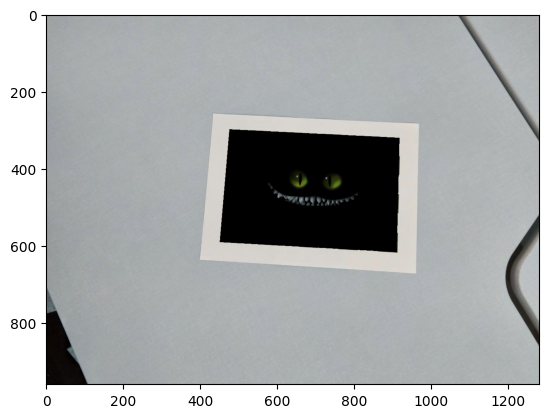

In [133]:
img_index = 0
_2d_corners_chessboard = np.float32([[476,299], [917,321], [910,617], [451,591]])
img = cv2.imread(img_names[img_index])
stregatto = cv2.imread("es3/stregatto.jpg")
h_2, w_2 = stregatto.shape[0], stregatto.shape[1]

dst = np.float32([[0, 0], [w_2-1, 0], [w_2-1, h_2-1], [0, h_2-1]])

M = cv2.getPerspectiveTransform(dst, _2d_corners_chessboard)
warped = cv2.warpPerspective(stregatto, M, (W, H)) # warp stregatto in an image with size (W, H) 

white = np.ones([h_2,w_2,3],dtype=np.uint8)*255
warp_mask = cv2.warpPerspective(white, M, (W, H)) # image all black except the white rectangle warped inside it
warp_mask = np.equal(warp_mask, np.array([0,0,0]))

warped[warp_mask] = img[warp_mask]

plt.imshow(warped)

## Exercise 4: Removal of perspective deformation 

Given a chessboard image remove the perspective deformation on the paper containing the chessboard and save it in a new image.

Get the 2D image coordinates using the Image Visualization Tool in LabSession3Exercise3VisualizationTool.ipynb

Test the exercise on "es4/pen.jpg"

Expected Results: 
<img src="LabSession3Images/perspective_deform.png" width=256>

**Tips (Only if needed)**
* Find the 4 points in the image of the corner of the paper 
* Understand what will be the dimension of the resulting image
* Find the Perspective Transformation
* Warp the paper into a new image (with the new dimensions you found)

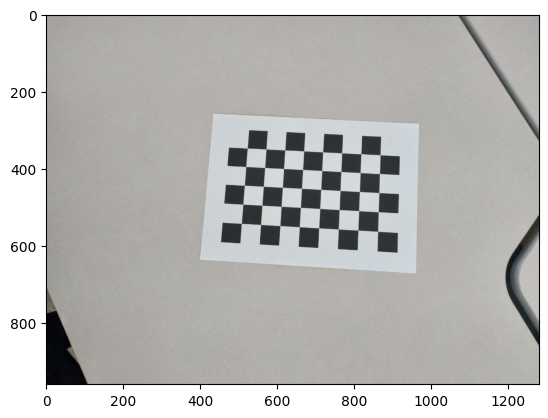

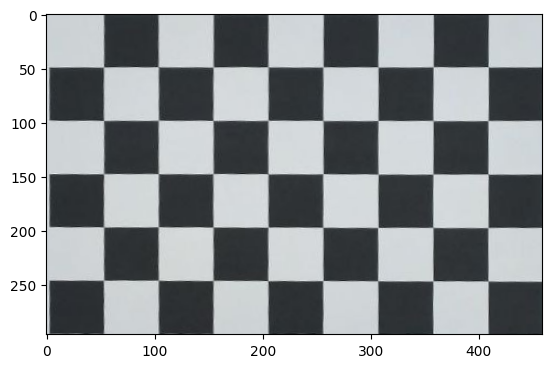

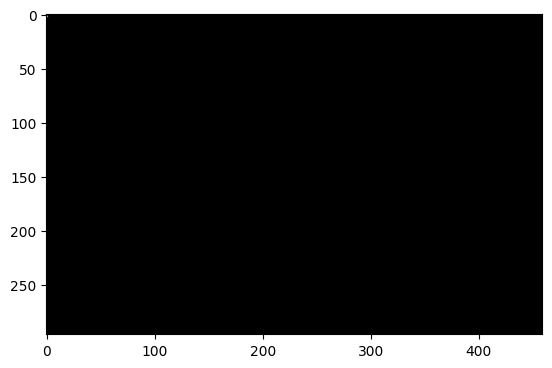

In [141]:
img_index = 0
_2d_corners_chessboard = np.float32([[476,299], [917,321], [910,617], [451,591]])

tl, tr, br, bl = _2d_corners_chessboard
img = cv2.imread(img_names[img_index])


widthA = np.linalg.norm(bl- br)
widthB = np.linalg.norm(tl- tr)
maxWidth = max(int(widthA), int(widthB))

heightA = np.linalg.norm(bl- tl)
heightB = np.linalg.norm(br- tr)
maxHeight = max(int(heightA), int(heightB))

dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]], dtype = "float32")

M = cv2.getPerspectiveTransform(_2d_corners_chessboard, dst)
warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()